<a href="https://colab.research.google.com/github/swguo/Fraud-Email-Analysis-with-BERT/blob/master/Fraud_Email_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Jan 14 05:40:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q -U watermark

## pip install -q 最少的結果輸出

In [4]:
!pip install transformers==3

     |████████████████████████████████| 757kB 7.7MB/s 
     |████████████████████████████████| 1.2MB 19.1MB/s 
     |████████████████████████████████| 3.0MB 31.5MB/s 
     |████████████████████████████████| 890kB 29.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0828ce9fc5e3e237fae3a69c5040f67cb7980e0279cc1c58c1ebdbc05b57b517
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.5
pandas 1.1.5
torch 1.7.0+cu101
transformers 3.0.0


In [6]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration
下載Fraud Email Dataset

In [8]:
!wget http://140.128.10.23:8080/fraud_email_.csv

--2021-01-14 05:40:56--  http://140.128.10.23:8080/fraud_email_.csv
Connecting to 140.128.10.23:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15940304 (15M) [application/octet-stream]
Saving to: ‘fraud_email_.csv’

fraud_email_.csv    100%[===================>]  15.20M  3.32MB/s    in 7.6s    

2021-01-14 05:41:04 (2.00 MB/s) - ‘fraud_email_.csv’ saved [15940304/15940304]



In [9]:
!ls -l

total 15572
-rw-r--r-- 1 root root 15940304 Oct  2  2019 fraud_email_.csv
drwxr-xr-x 1 root root     4096 Jan  6 18:10 sample_data


In [10]:
df = pd.read_csv("fraud_email_.csv")
df.head()

,Text,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,1
1,over. SidLet me know. Thx.,0
2,"Dear Friend,Greetings to you.I wish to accost ...",1
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1
4,Not a surprising assessment from Embassy.,0


In [11]:
df.shape

(11929, 2)

這裡我們有大約 11k 的範例。

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11928 non-null  object
 1   Class   11929 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 186.5+ KB


發現Text有遺漏，使用panda清洗資料，去除空值行

In [13]:
df.dropna(axis=0, how='any', inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11928 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11928 non-null  object
 1   Class   11928 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.6+ KB


很好，沒有在Text和review text 遺失value ! 再來要檢查class是否不平均

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


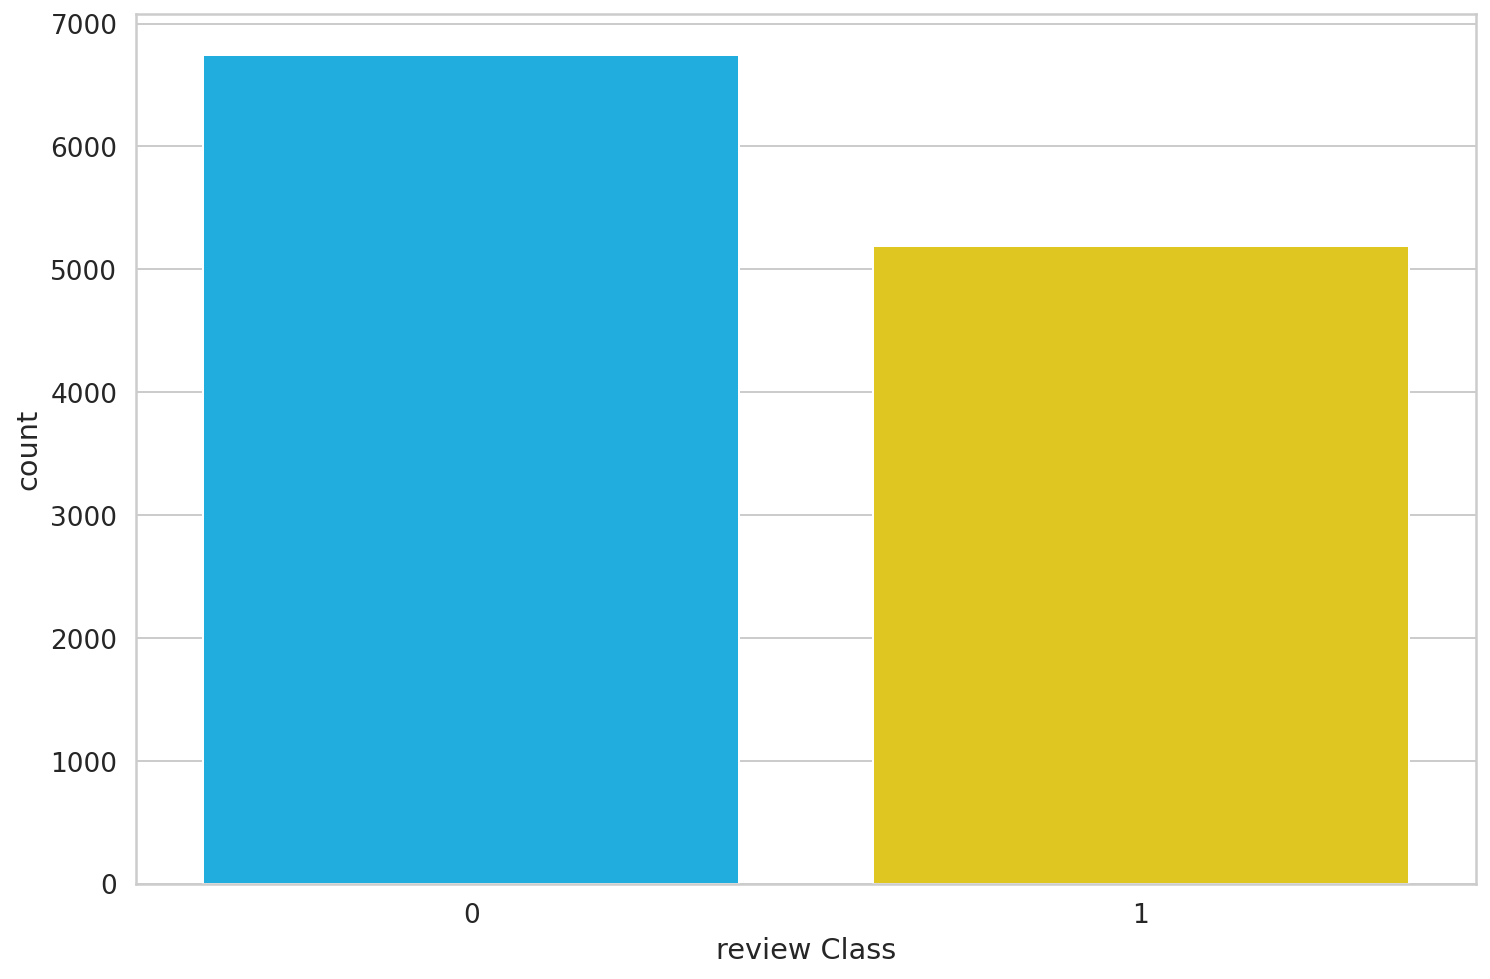

In [15]:
sns.countplot(df.Class)
plt.xlabel('review Class');

In [16]:
class_names = ['non-fraud', 'fraud']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


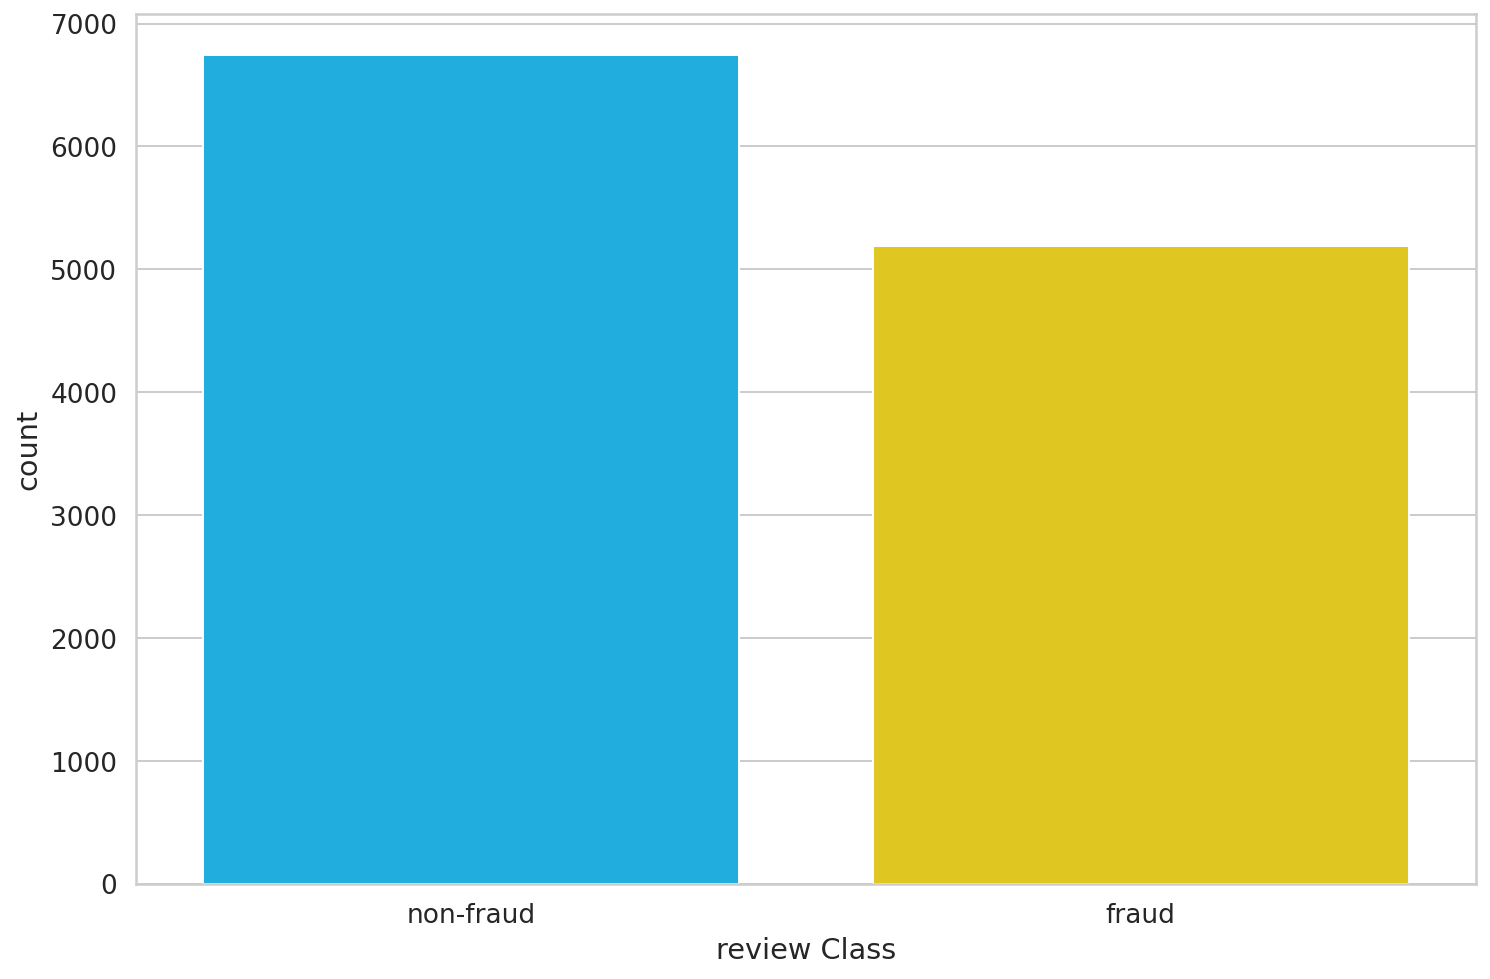

In [17]:
ax = sns.countplot(df.Class)
plt.xlabel('review Class')
ax.set_xticklabels(class_names);

## Data Preprocessing

In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [79]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## Clear Text Content

In [80]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

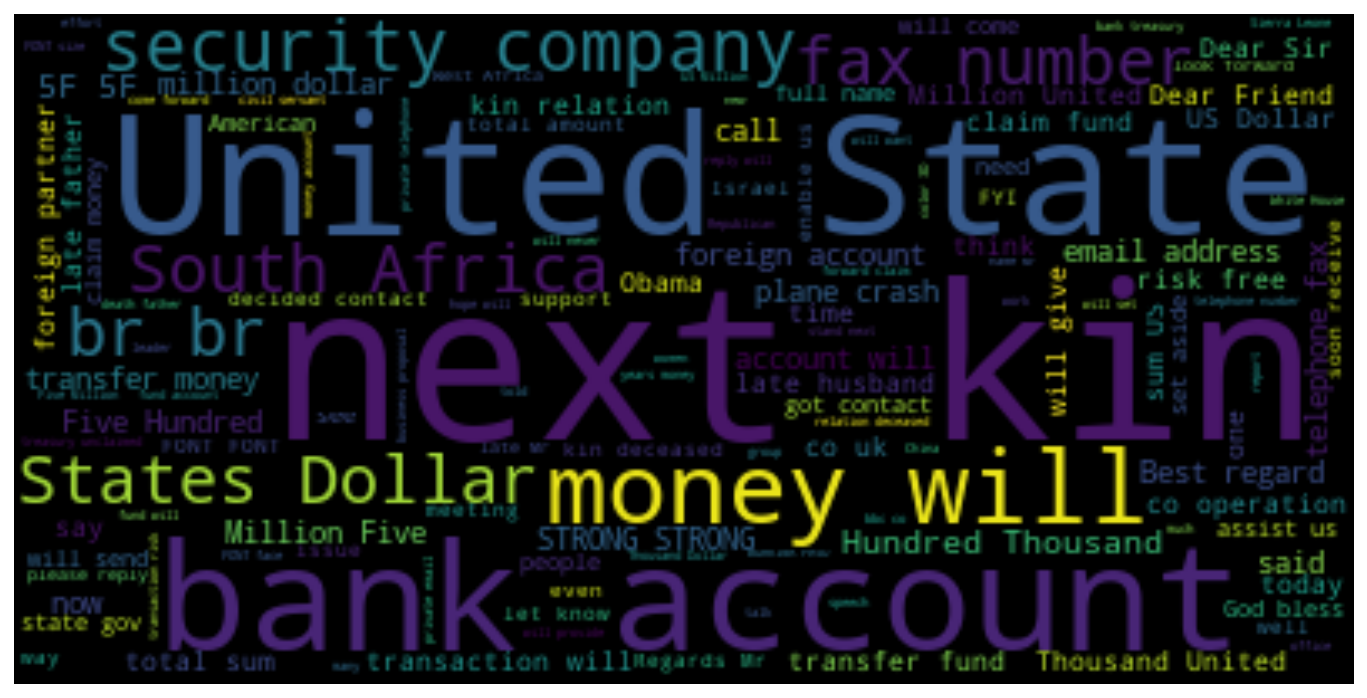

In [81]:
# Start with one review:
text = " ".join(review for review in df['Text'])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 清洗方式1

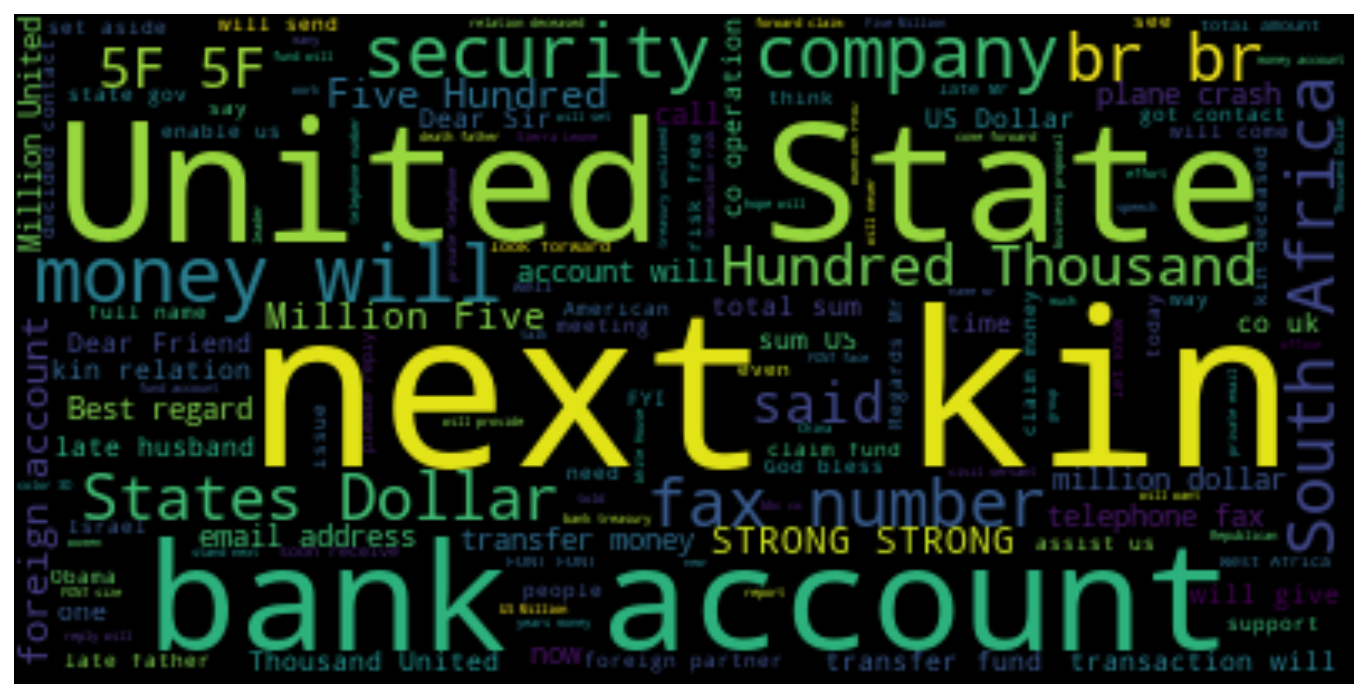

In [24]:
# 刪除非 ASCII 字元
df['Text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['Text'].replace({'DIV':''}, regex=True, inplace=True)
df['Text'].replace({'BR':''}, regex=True, inplace=True)
df['Text'].replace({'nbsp':''}, regex=True, inplace=True)
df['Text'].replace({'2E':''}, regex=True, inplace=True)
df['Text'].replace({'2C':''}, regex=True, inplace=True)
# Start with one review:
text = " ".join(review for review in df['Text'])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 清洗方式2

In [108]:
!pip install nltk

In [115]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [111]:
from nltp import Preprocessor

In [143]:
pre = Preprocessor(df['Text']).text_cleaner()


NameError: ignored

In [142]:
print(type(pre))
print(pre[:4]) #取前4筆看一下清洗結果
print(("df 筆數 {} , 請洗後筆數 {}").format(df.Text.count(),len(pre)))

<class 'list'>
['supply quality china exclusive dimension unbeatable price dear sir pleased inform one china largest export import sto ne company wanlistone group group subsidiary specialize q uarrying processing sale dimension stone slab tile dimen sion stone product building material sector specialty market e group operation based xiamen south china lar gest export import business portal china wanlistone owns operates various natural stone deposit square meter th e country addition quarry wanlistone fully automated pro cessing plant processing granite marble granite prod ucts wanlistone supply granite raw block form granite marble tile strip varying dimension memorial material specialty product local specifically export market group full rang china natural stone product including pink color g g g g yellow color g dark g black g', 'sidlet know thx', 'dear friend greeting wish accost request would immense benefit u executor will possible may tempted make fortune client situation cannot

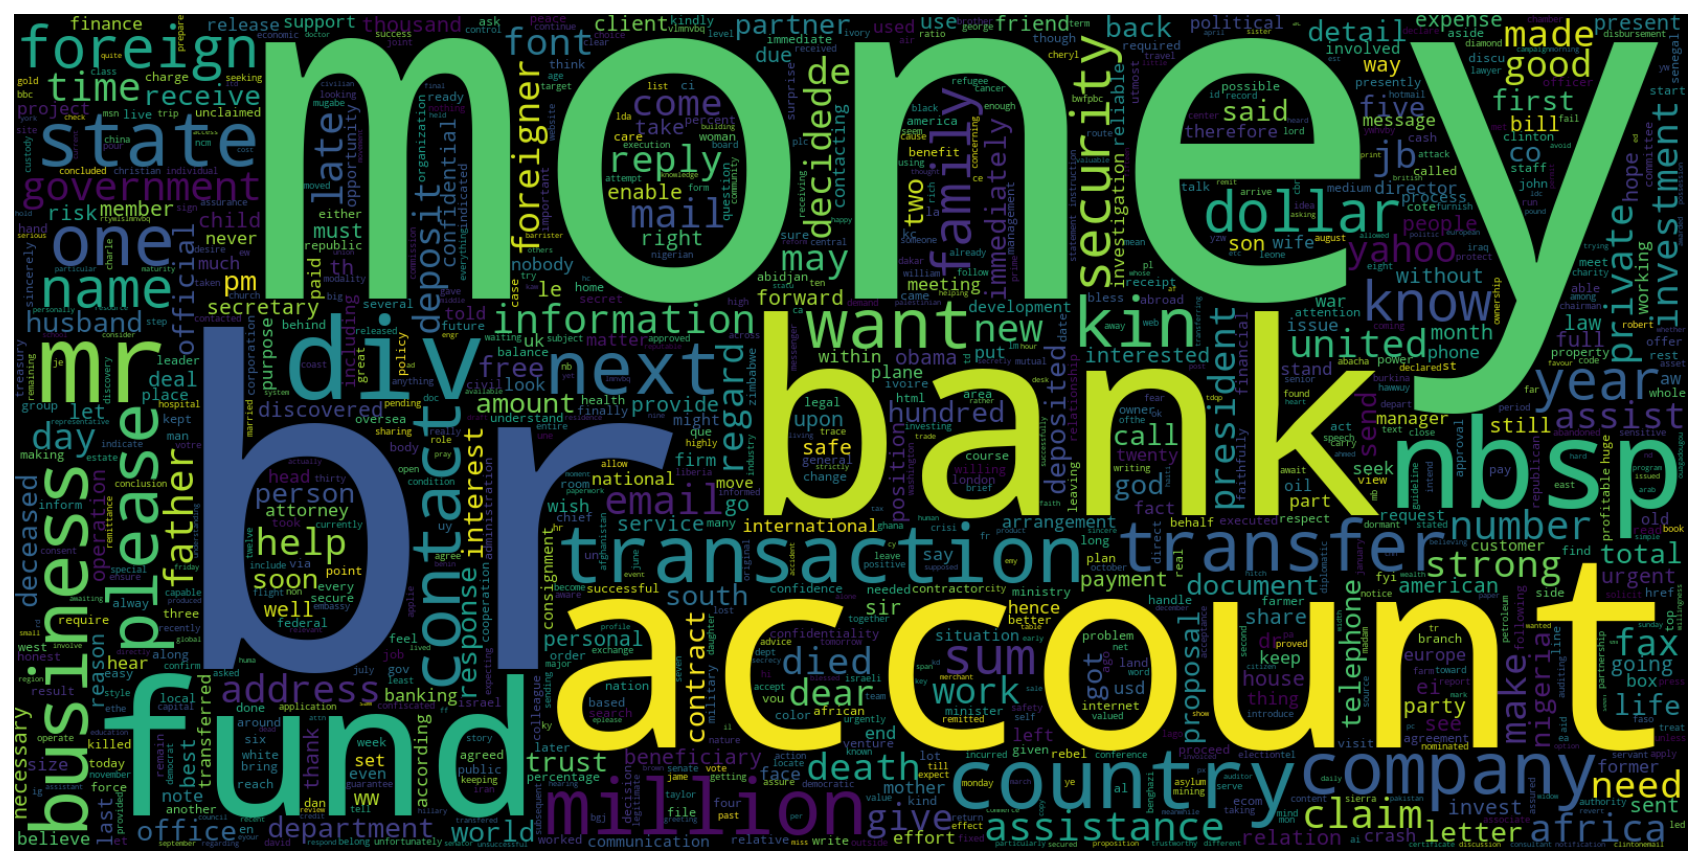

In [134]:

words = pre
plt.figure(figsize = (15,15))
word_cloud  = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(words))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [141]:
df.head(2)
for 
df.iloc[0,1]=0
df.head(2)

,Text,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,0
1,over. SidLet me know. Thx.,1


## Choosing Sequence Length
BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

BERT使用固定長度序列。 我們將使用一種簡單的策略來選擇最大長度。 讓我們存儲每個評論的令牌長度：

In [82]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

劃出email內文轉換成ids的分佈

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


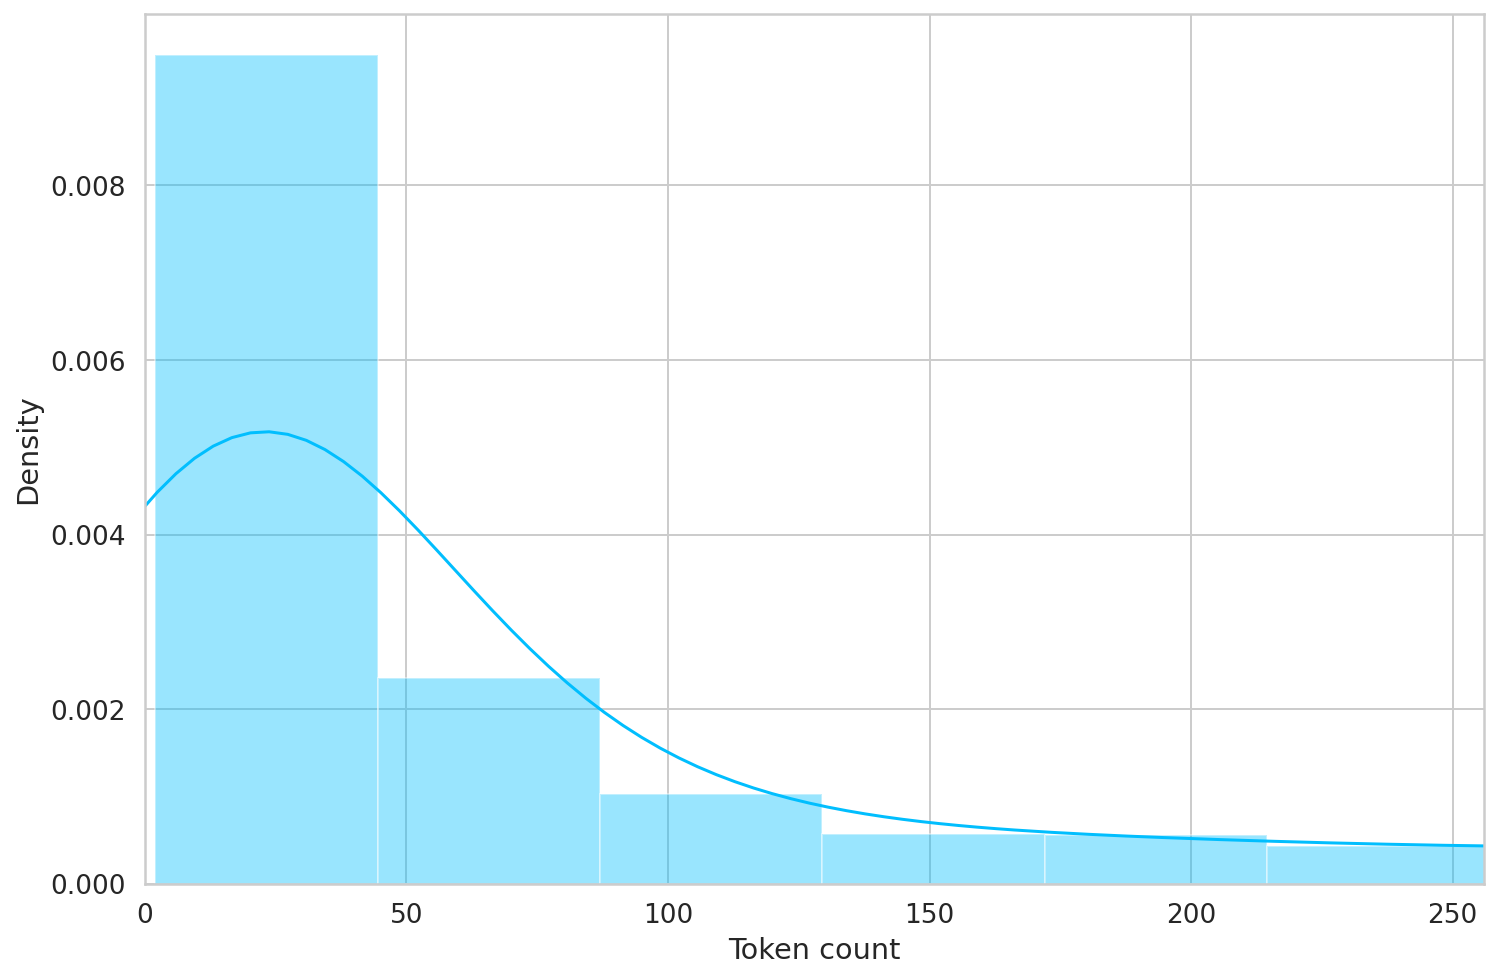

In [149]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

大部分的評論轉換後小於 150，不過安全起見長度定為200

In [84]:
MAX_LEN = 200

In [85]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'token_type_ids': encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [150]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [151]:
df_train.shape, df_val.shape, df_test.shape

((10735, 2), (596, 2), (597, 2))

In [152]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.Class.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [153]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [154]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])

In [148]:
print(data['input_ids'].shape)
print(data['input_ids'])
print(data['attention_mask'].shape)
print(data['token_type_ids'].shape)
print(data['targets'].shape)

torch.Size([16, 200])
tensor([[  101,   153,  3447,  ...,     0,     0,     0],
        [  101,   120,   130,  ...,  2036,  8215,   102],
        [  101, 17182, 25028,  ...,   128,   117,   102],
        ...,
        [  101,  1142,  2187,  ...,     0,     0,     0],
        [  101, 22572,  5075,  ...,     0,     0,     0],
        [  101, 12465,  2069,  ...,     0,     0,     0]])
torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


特徵矩陣X_train的尺寸為16×200（序列數×序列最大長度）。可視化一下是這樣的:

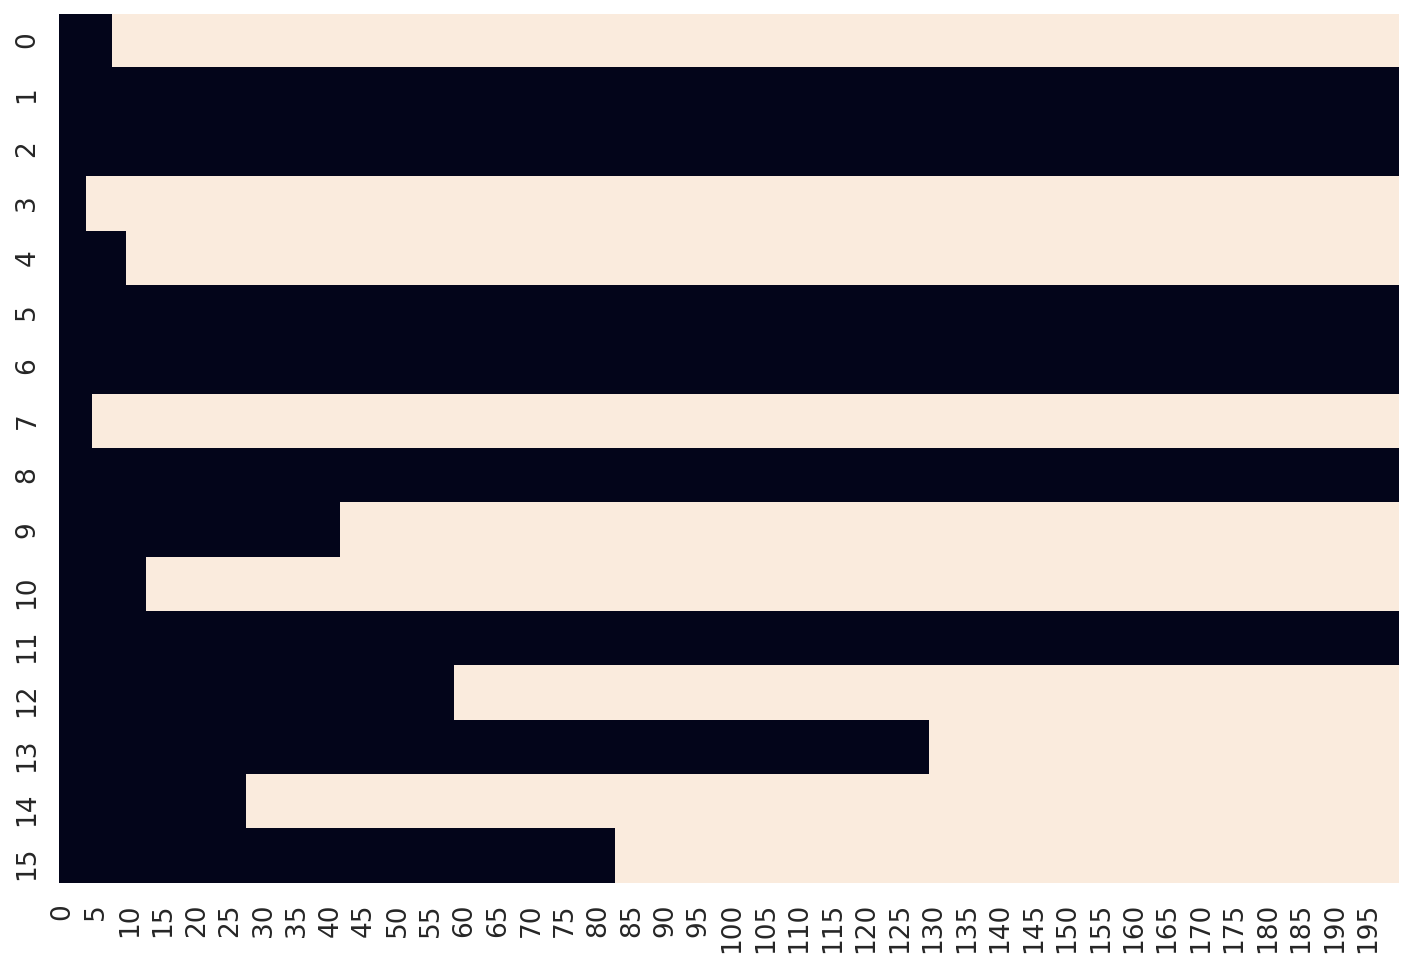

In [43]:
sns.heatmap(data['input_ids']==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [71]:
!git clone https://github.com/jessevig/bertviz.git

Cloning into 'bertviz'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1151 (delta 3), reused 8 (delta 3), pack-reused 1140
Receiving objects: 100% (1151/1151), 130.05 MiB | 30.05 MiB/s, done.
Resolving deltas: 100% (728/728), done.


## Fruad Email Classification with BERT and Hugging Face

In [164]:
print(PRE_TRAINED_MODEL_NAME)
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
#config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True, output_attentions=True)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

bert-base-cased


In [155]:
print(data['input_ids'].shape)

torch.Size([16, 200])


In [156]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

ValueError: ignored

In [161]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [127]:
bert_model.config.hidden_size

768

In [68]:
pooled_output.shape

torch.Size([1, 768])

In [157]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids,attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [159]:
model = SentimentClassifier(len(class_names))
#saved_model = torch.load('selective_stock_dataset_state-2.bin')
#model.load_state_dict(saved_model, strict=False)
model = model.to(device)

In [108]:
from bertviz.bertviz import head_view

In [163]:
# 用BertViz可视化
# 在 jupyter notebook 显示visualzation 
input_ids=data['input_ids'].to(device) 
attention_mask=data['attention_mask'].to(device)
'''
def call_html():
  import IPython
  

attention = model(input_ids=input_ids,attention_mask=attention_mask)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()  
print(attention)
print(tokens)
head_view(attention, tokens)
'''

'\ndef call_html():\n  import IPython\n  \n\nattention = model(input_ids=input_ids,attention_mask=attention_mask)[-1]\ninput_id_list = input_ids[0].tolist() # Batch index 0\ntokens = tokenizer.convert_ids_to_tokens(input_id_list)\ncall_html()  \nprint(attention)\nprint(tokens)\nhead_view(attention, tokens)\n'

In [168]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [169]:
F.relu(model(input_ids, attention_mask))

tensor([[0.4513, 0.0000],
        [0.8169, 0.0000],
        [0.5608, 0.0000],
        [1.8617, 0.0000],
        [0.6341, 0.0000],
        [0.7311, 0.0000],
        [0.3876, 0.0000],
        [0.6989, 0.0000],
        [1.1522, 0.0000],
        [1.5766, 0.0000],
        [1.4182, 0.0000],
        [0.8323, 0.0000],
        [0.2820, 0.0000],
        [1.1266, 0.0000],
        [0.7993, 0.0000],
        [0.8921, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)

In [170]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [171]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [172]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [173]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.039029264773123594 accuracy 0.9891010712622264
Val   loss 0.002925377674967565 accuracy 0.9983221476510067

Epoch 2/2
----------
Train loss 0.0021775116727090335 accuracy 0.999720540288775
Val   loss 0.010747032101311274 accuracy 0.9983221476510067

CPU times: user 8min 10s, sys: 5min 38s, total: 13min 48s
Wall time: 13min 56s


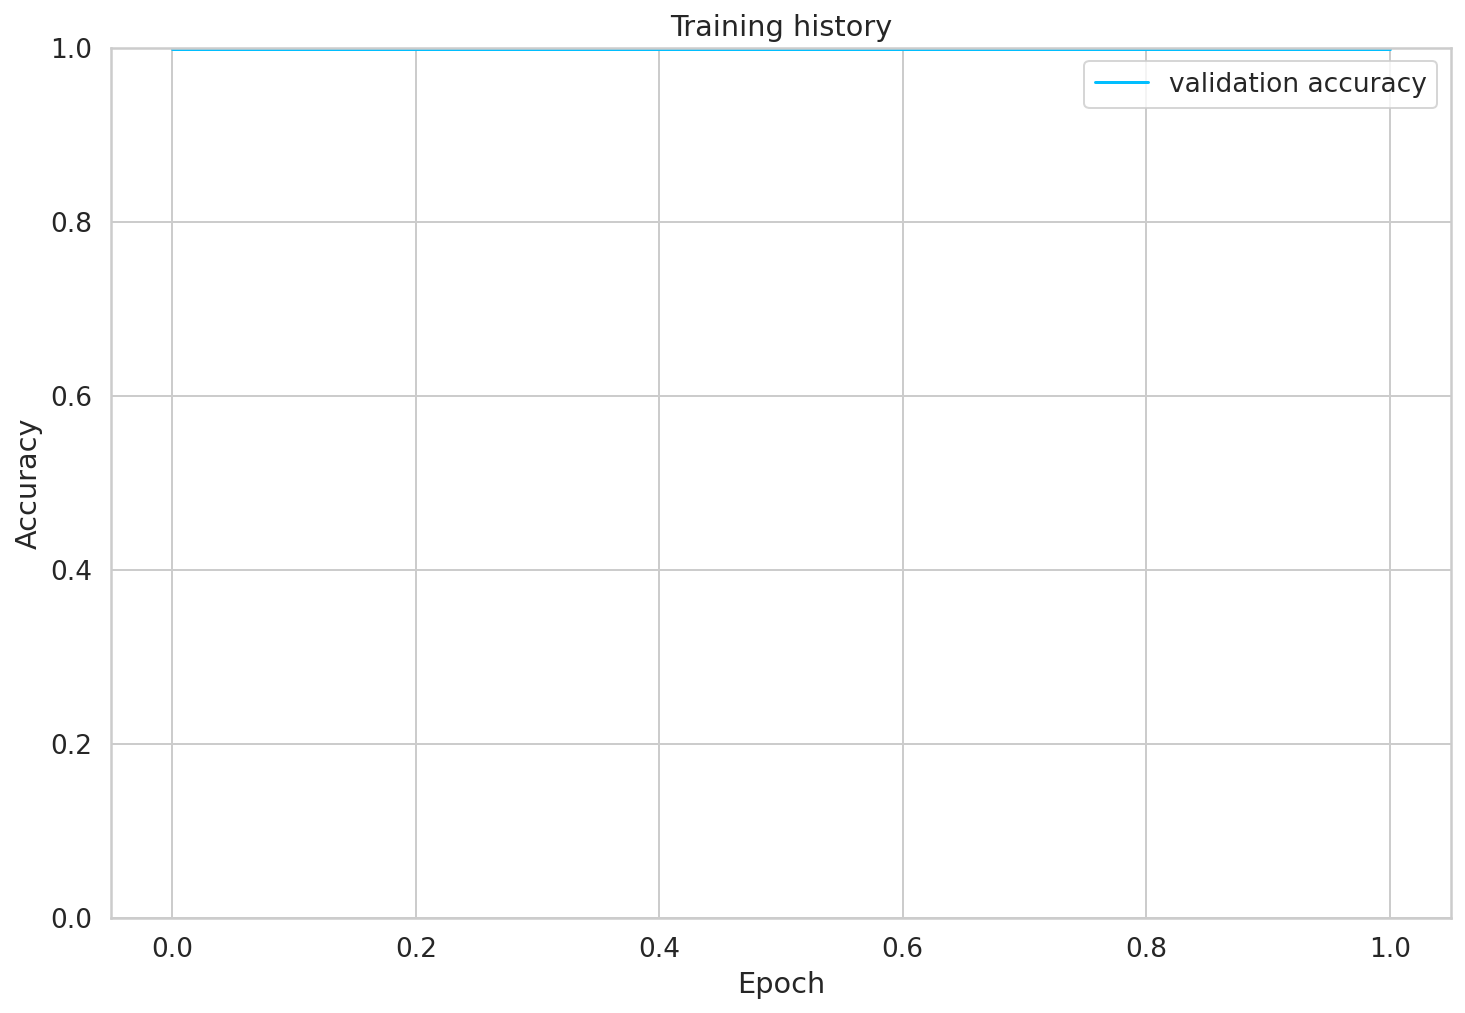

In [174]:
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [175]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9966499162479062

In [176]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [177]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [178]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   non-fraud       0.99      1.00      1.00       325
       fraud       1.00      0.99      1.00       272

    accuracy                           1.00       597
   macro avg       1.00      1.00      1.00       597
weighted avg       1.00      1.00      1.00       597



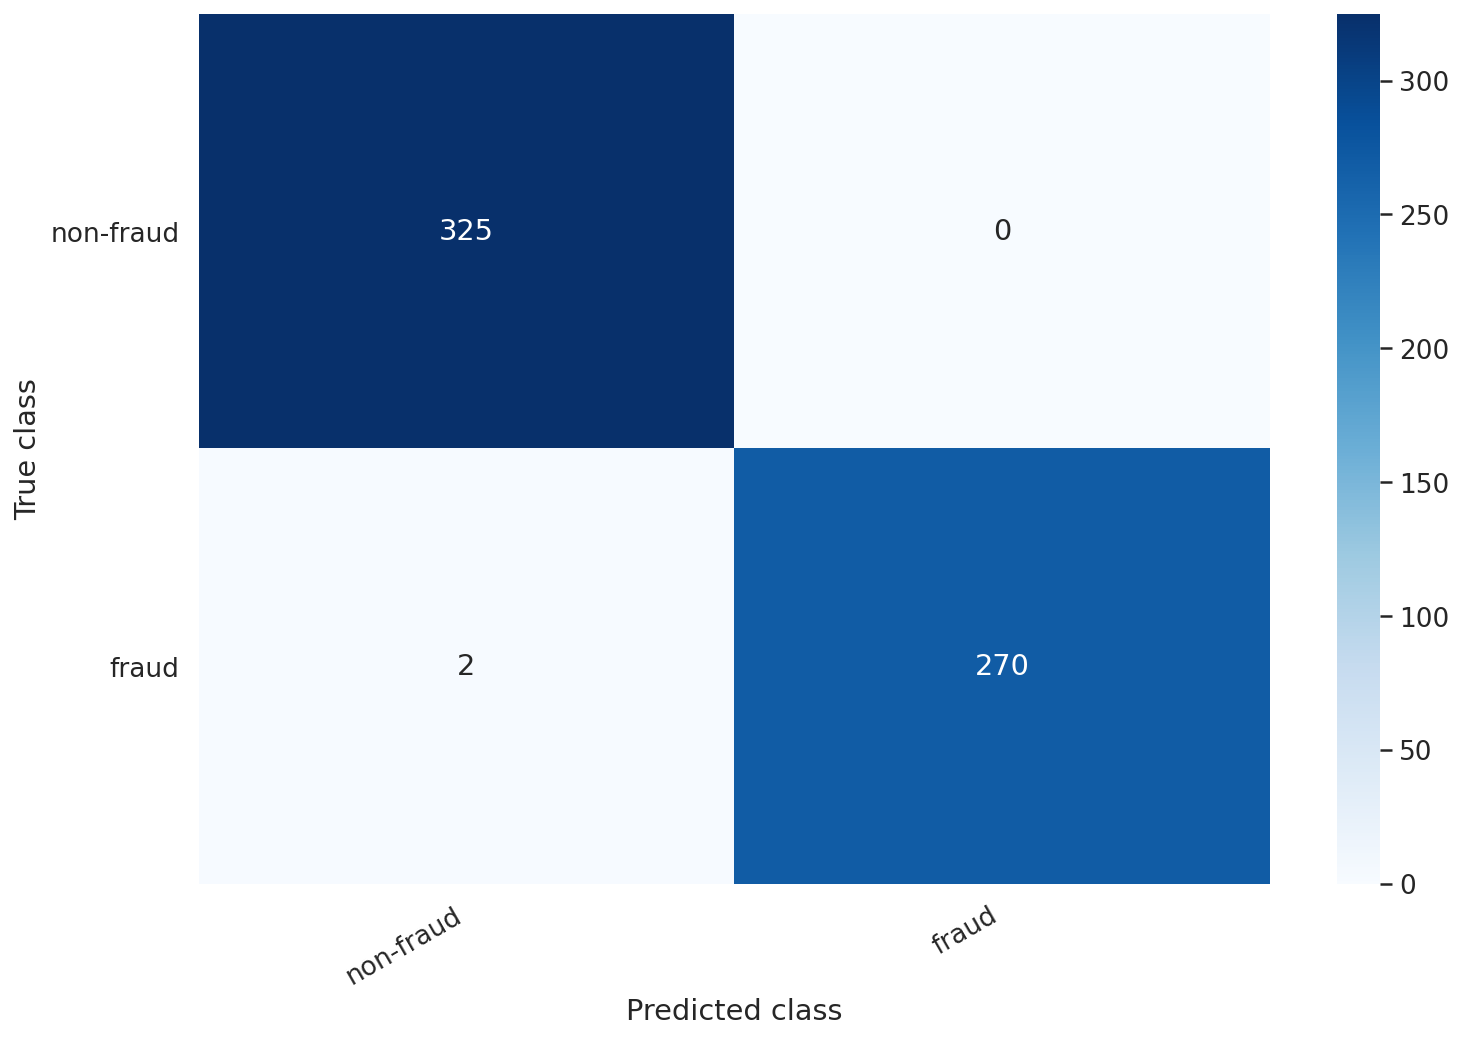

In [179]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [180]:
idx = 2

review_text = y_review_texts[idx]
true_class = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [181]:
print("\n".join(wrap(review_text)))
print()
print(f'True class: {class_names[true_class]}')

PIRFriday August 14 2009 5:46 PMH; Huma Abedin; CDM; Jake SullivanDr.
ARELEASE IN PART B6Her parting words to us when we got out of the vans
at State:

True class: non-fraud


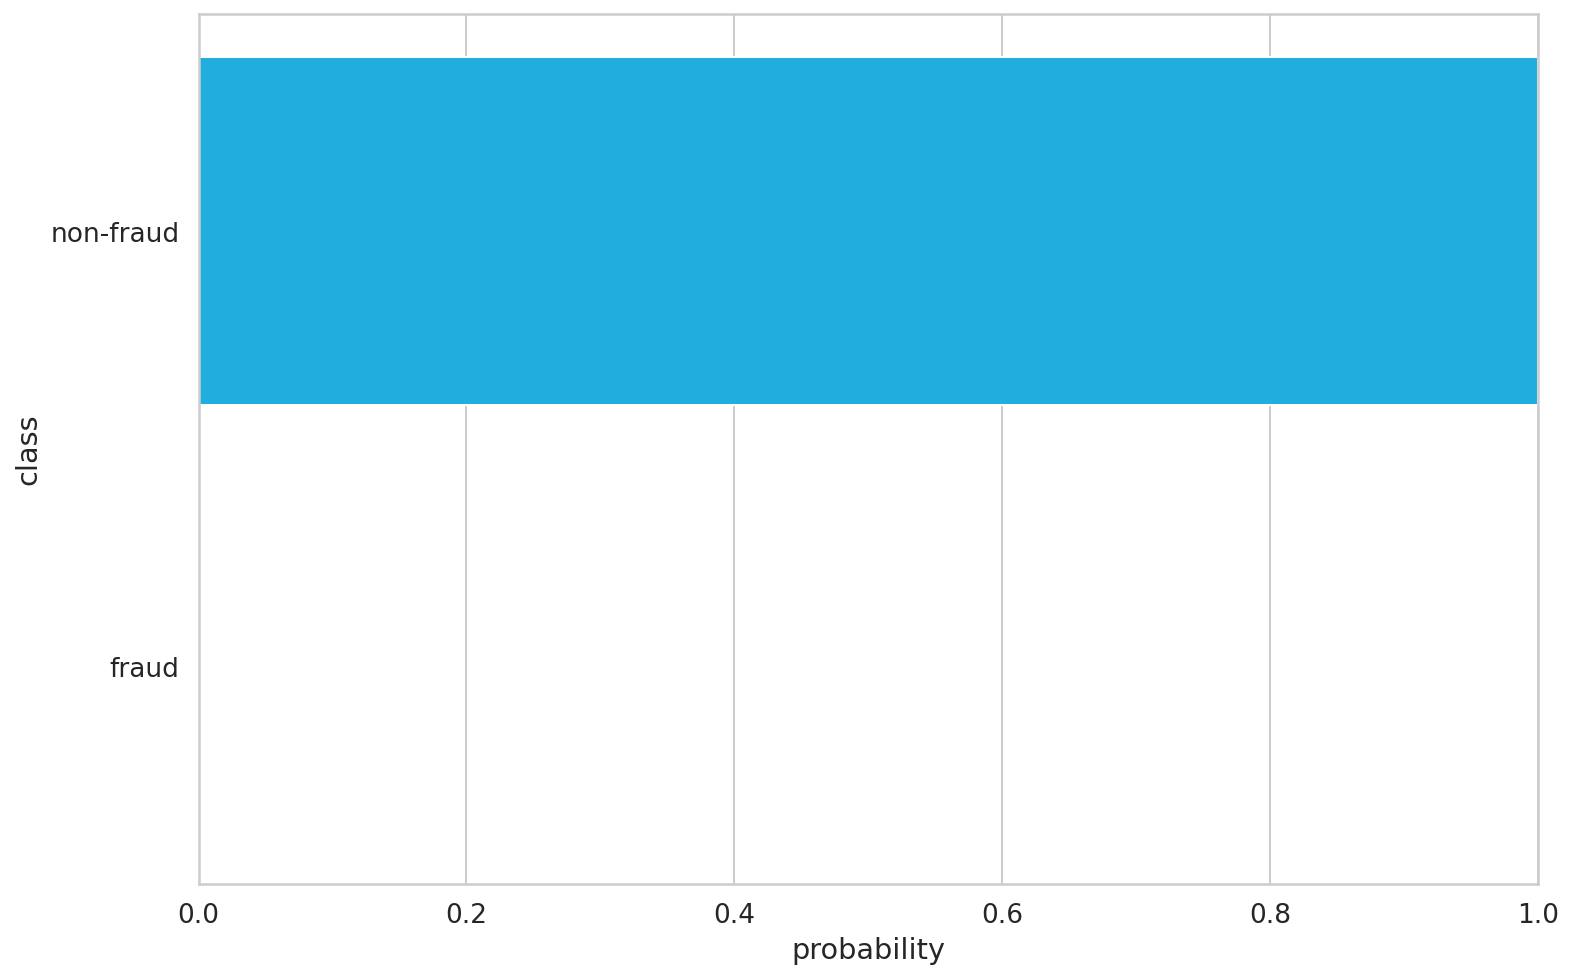

In [182]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('class')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Predicting on Raw Text

In [183]:
review_text = """DEAR FRIEND,

I AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY GUARD ON 16TH JAN. 2001.


THE INCIDENT OCCURRED IN OUR PRESENCE WHILE WE WERE HOLDING MEETING WITH HIS EXCELLENCY OVER THE FINANCIAL RETURNS FROM THE DIAMOND SALES IN THE AREAS CONTROLLED BY (D.R.C.) DEMOCRATIC REPUBLIC OF CONGO FORCES AND THEIR FOREIGN ALLIES ANGOLA AND ZIMBABWE, HAVING RECEIVED THE PREVIOUS DAY (USD$100M) ONE HUNDRED MILLION UNITED STATES DOLLARS, CASH IN THREE DIPLOMATIC BOXES ROUTED THROUGH ZIMBABWE.

MY PURPOSE OF WRITING YOU THIS LETTER IS TO SOLICIT FOR YOUR ASSISTANCE AS TO BE A COVER TO THE FUND AND ALSO COLLABORATION IN MOVING THE SAID FUND INTO YOUR BANK ACCOUNT THE SUM OF (USD$25M) TWENTY FIVE MILLION UNITED STATES DOLLARS ONLY, WHICH I DEPOSITED WITH A SECURITY COMPANY IN GHANA, IN A DIPLOMATIC BOX AS GOLDS WORTH (USD$25M) TWENTY FIVE MILLION UNITED STATES DOLLARS ONLY FOR SAFE KEEPING IN A SECURITY VAULT FOR ANY FURTHER INVESTMENT PERHAPS IN YOUR COUNTRY. 

YOU WERE INTRODUCED TO ME BY A RELIABLE FRIEND OF MINE WHO IS A TRAVELLER,AND ALSO A MEMBER OF CHAMBER OF COMMERCE AS A RELIABLE AND TRUSTWORTHY PERSON WHOM I CAN RELY ON AS FOREIGN PARTNER, EVEN THOUGH THE NATURE OF THE TRANSACTION WAS NOT REVEALED TO HIM FOR SECURITY REASONS.


THE (USD$25M) WAS PART OF A PROCEEDS FROM DIAMOND TRADE MEANT FOR THE LATE PRESIDENT LAURENT KABILA WHICH WAS DELIVERED THROUGH ZIMBABWE IN DIPLOMATIC BOXES. THE BOXES WERE KEPT UNDER MY CUSTODY BEFORE THE SAD EVENT THAT TOOK THE LIFE OF (MR. PRESIDENT).THE CONFUSION THAT ENSUED AFTER THE ASSASSINATION AND THE SPORADIC SHOOTING AMONG THE FACTIONS, I HAVE TO RUN AWAY FROM THE COUNTRY FOR MY DEAR LIFE AS I AM NOT A SOLDIER BUT A CIVIL SERVANT I CROSSED RIVER CONGO TO OTHER SIDE OF CONGO LIBREVILLE FROM THERE I MOVED TO THE THIRD COUNTRY GHANA WHERE I AM PRESENTLY TAKING REFUGE. 

AS A MATTER OF FACT, WHAT I URGENTLY NEEDED FROM YOU IS YOUR ASSISTANCE IN MOVING THIS MONEY INTO YOUR ACCOUNT IN YOUR COUNTRY FOR INVESTMENT WITHOUT RAISING EYEBROW. FOR YOUR ASSISTANCE I WILL GIVE YOU 20% OF THE TOTAL SUM AS YOUR OWN SHARE WHEN THE MONEY GETS TO YOUR ACCOUNT, WHILE 75% WILL BE FOR ME, OF WHICH WITH YOUR KIND ADVICE I HOPE TO INVEST IN PROFITABLE VENTURE IN YOUR COUNTRY IN OTHER TO SETTLE DOWN FOR MEANINGFUL LIFE, AS I AM TIRED OF LIVING IN A WAR ENVIRONMENT. 

THE REMAINING 5% WILL BE USED TO OFFSET ANY COST INCURRED IN THE CAUSE OF MOVING THE MONEY TO YOUR ACCOUNT. IF THE PROPOSAL IS ACCEPTABLE TO YOU PLEASE CONTACT ME IMMEDIATELY THROUGH THE ABOVE TELEPHONE AND E-MAIL, TO ENABLE ME ARRANGE FACE TO FACE MEETING WITH YOU IN GHANA FOR THE CLEARANCE OF THE FUNDS BEFORE TRANSFRING IT TO YOUR BANK ACCOUNT AS SEEING IS BELIEVING. 

FINALLY, IT IS IMPORTANT ALSO THAT I LET YOU UNDERSTAND THAT THERE IS NO RISK INVOLVED WHATSOEVER AS THE MONEY HAD NO RECORD IN KINSHASA FOR IT WAS MEANT FOR THE PERSONAL USE OF (MR. PRESIDEND ) BEFORE THE NEFARIOUS INCIDENT OCCURRED, AND ALSO I HAVE ALL THE NECESSARY DOCUMENTS AS REGARDS TO THE FUNDS INCLUDING THE (CERTIFICATE OF DEPOSIT), AS I AM THE DEPOSITOR OF THE CONSIGNMENT."""

In [184]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [185]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Class  : {class_names[prediction]}')

Review text: DEAR FRIEND,

I AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY GUARD ON 16TH JAN. 2001.


THE INCIDENT OCCURRED IN OUR PRESENCE WHILE WE WERE HOLDING MEETING WITH HIS EXCELLENCY OVER THE FINANCIAL RETURNS FROM THE DIAMOND SALES IN THE AREAS CONTROLLED BY (D.R.C.) DEMOCRATIC REPUBLIC OF CONGO FORCES AND THEIR FOREIGN ALLIES ANGOLA AND ZIMBABWE, HAVING RECEIVED THE PREVIOUS DAY (USD$100M) ONE HUNDRED MILLION UNITED STATES DOLLARS, CASH IN THREE DIPLOMATIC BOXES ROUTED THROUGH ZIMBABWE.

MY PURPOSE OF WRITING YOU THIS LETTER IS TO SOLICIT FOR YOUR ASSISTANCE AS TO BE A COVER TO THE FUND AND ALSO COLLABORATION IN MOVING THE SAID FUND INTO YOUR BANK ACCOUNT THE SUM OF (USD$25M) TWENTY FIVE MILLION UNITED STATES DOLLARS ONLY, WHICH I DEPOSITED WITH A SECURITY COMPANY IN GHANA, IN A DIPLOMATIC BOX AS GOLDS WORTH (USD$25M) TWENTY FIVE MILLION UNITED STATES DOLLARS ONLY FOR SAFE KEEPING IN A SECURITY 

In [186]:
!ls -l

total 438760
-rw-r--r-- 1 root root 433330273 Jan 14 03:38 best_model_state.bin
-rw-r--r-- 1 root root      7733 Jan 14 00:45 download
drwx------ 6 root root      4096 Jan 14 02:01 drive
-rw-r--r-- 1 root root  15940304 Oct  2  2019 fraud_email_.csv
drwxr-xr-x 1 root root      4096 Jan  6 18:10 sample_data


In [187]:
# 取得google drive存取權限
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [188]:
!ls -l /content/drive/MyDrive/中興大學/普及資料實驗室/

total 20
drwx------ 2 root root 4096 Jan 14 02:01  Fraud_Email_Analysis_with_Bert
drwx------ 2 root root 4096 Sep 11 01:15  SemEval-2021
drwx------ 2 root root 4096 Jan 13 11:31  Sentiment_Analysis_with_Bert
drwx------ 2 root root 4096 Jul 17 08:20  實驗室行政文件
drwx------ 2 root root 4096 Jul 17 08:20 '技術文件 教育訓練'


In [189]:
!cp best_model_state.bin /content/drive/MyDrive/中興大學/普及資料實驗室/Fraud_Email_Analysis_with_Bert/best_model_statev2.bin